# 수치 안정성(numerical stability) 및 초기화

지금까지 우리는 다층 퍼셉트론(multilayer perception)을 구현하는데 필요한 도구, 회귀와 분류의 문제를 어떻게 풀 수 있는지, 그리고 모델의 용량을 어떻게 제어해야하는지에 대해서 다뤘습니다. 하지만, 파라미터의 초기화는 당연한 것으로 간주하면서, 특별히 중요하지 않은 것으로 단순하게 가정했습니다. 이 절에서는 이것들에 대해서 자세히 살펴보고, 유용한 경험적 방법론에 대해서 논의하겠습니다.

두번째로 우리는 활성화 함수(activation function) 선택에 큰 관심을 두지 않았습니다. 실제로 얕은 네트워크에서는 크게 중요하지 않지만, 딥 네트워크 (deep network)에서는 비선형성과 초기화의 선택이 최적화 알고리즘을 빠르게 수렴시키는데 중요한 역할을 합니다. 이 이슈들을 중요하게 생각하지 않으면 그래디언트 소실(vanishing) 또는 폭발(exploding)이 발생할 수 있습니다.

## 그래디언트 소실(vanishing)과 폭발(exploding)

입력이  $\mathbf{x}$ , 출력이  $\mathbf{o}$ 이고 $d$ 층을 갖는 딥 네트워크를 예로 들겠습니다. 각 층은 다음을 만족합니다.

$$\mathbf{h}^{t+1} = f_t (\mathbf{h}^t) \text{ 이고, 따라서 } \mathbf{o} = f_d \circ \ldots \circ f_1(\mathbf{x})$$

모든 활성화(activation)들과 입력들이 벡터인 경우, $t$ 번째 층의 함수 $f_t$ 와 관련된 파라미터 $\mathbf{W}_t$ 의 임의의 세트에 대한  $\mathbf{o}$ 의 그래디언트(gradient)는 다음과 같이 표현됩니다.

$$\partial_{\mathbf{W}_t} \mathbf{o} = \underbrace{\partial_{\mathbf{h}^{d-1}} \mathbf{h}^d}_{:= \mathbf{M}_d} \cdot \ldots \cdot \underbrace{\partial_{\mathbf{h}^{t}} \mathbf{h}^{t+1}}_{:= \mathbf{M}_t} \underbrace{\partial_{\mathbf{W}_t} \mathbf{h}^t}_{:= \mathbf{v}_t}.$$

다르게 말하면, 위 공식은 $d-t$ 개의 행렬  $\mathbf{M}_d \cdot \ldots \cdot \mathbf{M}_t$ 과 그래디언트(gradient) 벡터  $\mathbf{v}_t$ 의 곱입니다. 너무 많은 확률을 곱할 때 산술적인 언더플로우(underflow)를 경험할 때와 비슷한 상황이 발생합니다. 이 문제를 로그 공간으로 전환시켜서, 즉 문제를 가수(mantissa)에서 수치 표현의 지수로 이동시켜서 완화할 수 있었습니다. 처음에 행렬들 $M_t$ 은 다양한 고유값(eigenvalue)들을 갖을 것입니다. 어떤 것들은 작을 수도, 어떤 것은 클 수도 있습니다. 특히 그것들의 곱이 아주 크거나 아주 작을 수도 있습니다. 이것은 수치적인 표현의 문제일 뿐만 아니라 최적화 알고리즘이 수렴되지 않을 수 있다는 것을 의미합니다. 아주 큰 그래디언트(gradient)가 되거나, 너무 조금씩 업데이트가 되기도 합니다. 앞의 경우에는, 파라미터가 너무 커질 것이고, 후자의 경우에는 그래디언트 소실(vanishing gradient)이 되어버려서 더 이상 의미 있는 진척을 만들어 내지 못하게 됩니다.

### 그래디언트 폭발(exploding gradient)

좀 더 자세히 설명해 보겠습니다. 하나의 행렬을 선택한 후 100개의 가우시안 랜덤 행렬을 선택해서 모두 곱합니다. 우리가 선택한 스캐일링으로 인해서 행렬의 곱은 너무 커지게 됩니다. 이러한 일이 딥 네트워크에서 발생한다면, 알고리즘을 수렴하게 만들기 어려워집니다.

In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import nd, autograd
from matplotlib import pyplot as plt

M = nd.random.normal(shape=(4,4))
print('A single matrix', M)
for i in range(100):
    M = nd.dot(M, nd.random.normal(shape=(4,4)))

print('After multiplying 100 matrices', M)

A single matrix 
[[ 2.2122064   0.7740038   1.0434405   1.1839255 ]
 [ 1.8917114  -1.2347414  -1.771029   -0.45138445]
 [ 0.57938355 -1.856082   -1.9768796  -0.20801921]
 [ 0.2444218  -0.03716067 -0.48774993 -0.02261727]]
<NDArray 4x4 @cpu(0)>
After multiplying 100 matrices 
[[ 3.1575275e+20 -5.0052276e+19  2.0565092e+21 -2.3741922e+20]
 [-4.6332600e+20  7.3445046e+19 -3.0176513e+21  3.4838066e+20]
 [-5.8487235e+20  9.2711797e+19 -3.8092853e+21  4.3977330e+20]
 [-6.2947415e+19  9.9783660e+18 -4.0997977e+20  4.7331174e+19]]
<NDArray 4x4 @cpu(0)>


### 그래디언트 소실(vanishing gradient)

반대의 문제인 그래디언트 소실(vanishing gradient)도 나쁜 경우입니다. 주요 원인 중의 하나는 각 층의 선형 연산과 함께 엮이는 활성화 함수(activation function)  $\sigma$ 입니다. 역사적으로는 [Multilayer Perceptrons](../chapter_deep-learning-basics/mlp.ipynb) 절에서 소개했던 sigmoid 함수  $(1 + \exp(-x))$ 가 유명한 활성화 함수(activation function)였습니다. 이 함수를 비선형 활성화 함수(activation function)로 사용했을 때 문제가 될 수 있는지를 보기 위해서, 이 함수에 대해서 간단하게 살펴보겠습니다.

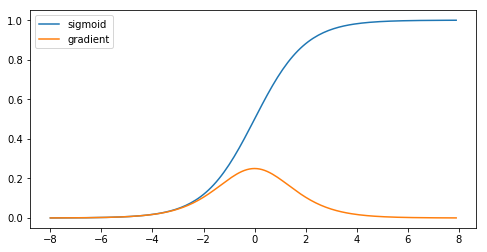

In [2]:
x = nd.arange(-8.0, 8.0, 0.1)
x.attach_grad()
with autograd.record():
    y = x.sigmoid()
y.backward()

plt.figure(figsize=(8, 4))
plt.plot(x.asnumpy(), y.asnumpy())
plt.plot(x.asnumpy(), x.grad.asnumpy())
plt.legend(['sigmoid', 'gradient'])
plt.show()

위 그림에서 보이는 것처럼 sigmoid의 그래디언트는 아주 큰 수나 아주 작은 수에서 소멸합니다. 체인룰(chain rule)로 인해서, 활성화(activation)들이 $[-4, 4]$ 범위에 들어가지 않지 않으면 전체 곱의 그래디언트(gradient)는 소멸될 수 있다는 것을 의미합니다. 층을 많이 사용하는 경우, 이 현상이 어떤 층에서 일어날 가능성이 높습니다.  ReLU $\max(0,x)$ 가 소개되기 전까지는 이 문제가 딥 네트워크 학습의 단점이었습니다. 그 결과 ReLU 가 활성화(activation)로 설계할 때 기본 선택이 되었습니다.

### 대칭성

딥 네트워크 디자인의 마지막 문제는 파라미터화에 내재된 대칭입니다. 두 개의 은닉
유닛(hidden unit), $h_1$ and $h_2$ 을 갖는 한 개의 은닉층(hidden layer)를 가지고
있는 딥 네트워크를 가정하겠습니다. 이 경우, 첫번째 층의 가중치 $\mathbf{W}_1$ 를
뒤집고, 두번째 층의 결과도 뒤집을 경우, 동일한 함수를 얻게 됩니다. 좀 더
일반적으로 각 층의 은닉 유닛(hidden unit) 간에는 치환 대칭성(permutation
symmetry)이 존재합니다. 이것은 이론적으로만 말썽이되는 것이 아닙니다. 어떤 층의
파라미터를 모두 0으로 초기화를 하거나 ($\mathbf{W}_l = 0$ ),  $\mathbf{W}_l$ 의
모든 값을 동일하게 설정한다고 가정합니다. 이 경우, 모든 차원의
그래디언트(gradient)들이 같게 되고, 주어진 층에 내재된 표현력을 전혀 사용할 수
없게 됩니다. 사실, 그 은닉층(hidden layer)는 단일 유닛(single unit) 처럼
동작합니다.

## 파라미터 초기화

위 문제를 해결하거나 최소한 완화시키는 방법은 가중치 벡터의 초기화를 조심하게 하는 것입니다. 이렇게 해서 적어도 초기의 그래디언트(gradient)가 소멸되지 않게 하고, 네트워크 가중치들이 너무 커지지 않게 합리적인 범위에 존재하게 할 수 있습니다. 최적화에서의 추가적 조치나 적합한 정규화(regularization)을 통해서 너무 나빠지는 것을 막을 수 있습니다. 이제 방법들에 대해서 알아보겠습니다.

### 기본 초기화

[“Concise Implementation of Linear Regression”](linear-regression-gluon.ipynb) 절에서 우리는 `net.initialize(init.Normal(sigma=0.01))` 을 이용해서 가중치의 초기값으로 정규 분포에서 임의의 수 선택하는 방법을 사용했습니다. 초기화 방법을 명시하지 않은 경우, 즉, `net.initialize()` 를 호출하는 경우에 MXNet은 기본 랜덤 초기화 방법을 적용합니다. 이는, 가중치의 각 원소는  $U[-0.07, 0.07]$ 범위의 균일 분포에서 선택된 값을 갖고, 편향(bias) 파라미터는 모두 0으로 설정됩니다. 일반적인 문제의 크기에서 이 두 방법은 상당히 잘 작동합니다.

### Xavier 초기화

어떤 층의 은닉 유닛(hidden unit) $h_{i}$에 적용된 활성화(activation)의 범위 분포를 살펴보겠습니다. 이 값들은 다음과 같이 계산됩니다.

$$h_{i} = \sum_{j=1}^{n_\mathrm{in}} W_{ij} x_j$$

가중치 $W_{ij}$ 들은 같은 분포에서 서로 독립적으로 선택됩니다. 이 분포는 평균이 0이고 분산이  $\sigma^2$ 라고 가정하겠습니다. (하지만, 이 분포가 가우시안(Gaussian) 이어야 한다는 것은 아니고, 단지 평균과 분산이 필요할 뿐입니다.)  층의 입력  $x_j$ 를 제어할 수 있는 방법이 없지만, 그 값들의 평균이 0이고 분산이 $\gamma^2$ 이고,  $\mathbf{W}$ 과는 독립적이라는 다소 비현실적인 가정을 하겠습니다. 이 경우,  $h_i$ 의 평균과 분산을 다음과 같이 계산할 수 있습니다.
$$
\begin{aligned}
    \mathbf{E}[h_i] & = \sum_{j=1}^{n_\mathrm{in}} \mathbf{E}[W_{ij} x_j] = 0 \\
    \mathbf{E}[h_i^2] & = \sum_{j=1}^{n_\mathrm{in}} \mathbf{E}[W^2_{ij} x^2_j] \\
        & = \sum_{j=1}^{n_\mathrm{in}} \mathbf{E}[W^2_{ij}] \mathbf{E}[x^2_j] \\
        & = n_\mathrm{in} \sigma^2 \gamma^2
\end{aligned}
$$

$n_\mathrm{in} \sigma^2 = 1$ 을 적용하면 분산을 고정시킬 수 있습니다. 이제 back propagation을 고려해봅니다. 가장 상위층들로부터 전달되는 그래디언트(gradient) 와 함께 비슷한 문제를 만나게 됩니다. 즉,  $\mathbf{W} \mathbf{w}$ 대신에  $\mathbf{W}^\top \mathbf{g}$ 를 다뤄야합니다. 여기서 $\mathbf{g}$ 는 상위층으로부터 전달되는 그래디언트(gradient)를 의미합니다. 포워드 프로퍼게이션(forward propagation)에서와 같은 논리로,  $n_\mathrm{out} \sigma^2 = 1$ 이 아닐 경우에는 그래디언트(gradient)의 분산이 너무 커질 수 있습니다. 이 상황이 우리를 다음과 같은 딜레마에 빠지게 합니다. 즉, 우리는 두 조건을 동시에 만족시킬 수 없습니다. 대신, 다음은 조건은 쉽게 만족시킬 수 있습니다.
$$
\begin{aligned}
\frac{1}{2} (n_\mathrm{in} + n_\mathrm{out}) \sigma^2 = 1 \text{ 또는 동일하게 }
\sigma = \sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}
\end{aligned}
$$

이것이 2010년에  [Xavier Glorot and Yoshua Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) 이 제안한 Xavier 초기화의 기본이 되는 논리입니다. 이 방법은 실제로 충분이 잘 작동합니다. 가우시안(Gaussian) 확률 변수에서 Xavier 초기화는 평균이 0이고 분산이  $\sigma^2 = 2/(n_\mathrm{in} + n_\mathrm{out})$ 인 정규 분포에서 값을 선택합니다.  $U[-a, a]$ 에 균등하게 분포한 확률 변수의 경우, 분산이  $a^2/3$ 이 됩니다.  $a^2/3$ 을  $\sigma^2$ 에 대한 조건에 대입하면 다음과 같은 분포의 초기화를 할 수 있습니다.

$U\left[-\sqrt{6/(n_\mathrm{in} + n_\mathrm{out})}, \sqrt{6/(n_\mathrm{in} + n_\mathrm{out})}\right]$.

### 그 외의 것들

위 내용은 아주 일부입니다. MXNet의 `mxnet.initializer` 모듈은 10가지 이상의 경험적 방법들을 제공합니다. 이 방법들은 슈퍼 해상도(superresolution), 시퀀스(sequence) 모델 또는 관련된 문제들에서 파라미터들이 연관된 경우에 사용할 수 있습니다. 이 모듈이 제공하는 것들을 살펴보는 것을 권장합니다.

## 요약

* 그래디언트 소멸(Vanishing gradient)와 그래디언트 폭발(exploding gradient)은 아주 깊은 네트워크에서 발생하는 흔한 문제입니다. 이를 위해서 그래디언트(gradient)와 파라미터가 잘 통제되도록 하는 것이 중요합니다.
* 초기화 방법은 최소한 초기의 그래디언트(gradient)들이 너무 커지거나 너무 작아지지 않도록 하는데 필요합니다.
* ReLU는 그래디언트 소멸(vanishing gradient) 문제 중에 하나를 해결합니다. 즉, 매우 큰 입력에 대해서 그래디언트(gradient) 가 사라지는 것을 해결합니다. 이는 수렴을 아주 빠르게 가속화해줍니다.
* 랜덤 초기화는 최적화를 수행하기 전 대칭을 깨 주는데 중요합니다.

## 문제

1. 치환 대칭성(permutation symmetry) 이외에 대칭성(symmetry)를 깨는 다른 사례를 디자인할 수 있나요?
1. 선형 회귀나 softmax 회귀에서 모든 가중치 파라미터를 같은 값으로 초기화할 수 있나요?
1. 두 행렬의 곱에서 고유값(eigenvalue)들의 해석적 범위(analytic bound)를 찾아보세요. 그래디언트(gradient)들을 잘 제어되도록 하는 것에 대해서 어떤 것을 알 수 있나요?
1. 어떤 항들의 값이 커지고 있는 것을 알게 된 경우, 이 후에 이를 고칠 수 있나요?  [You, Gitman and Ginsburg, 2017](https://arxiv.org/pdf/1708.03888.pdf) 의 LARS 논문을 참고해보세요.

## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2345)

![](../img/qr_numerical-stability-and-init.svg)